In [159]:
from collections import Counter
import torch
import torch.nn as nn
from torch.optim import Adam
import random
import numpy as np
import math
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
!nvidia-smi

Mon Mar  4 02:57:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              39W / 300W |   2844MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [160]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


In [139]:
#Hyperparameters
# embed_size = 100#size for each word embedding
# hidden_size=256
# num_layers=1
# num_epochs=20
# batch_size=100
# dropout_rate=0.5
# sequence_length=10#no of words in a sequence
# word_frequency=15
# learning_rate=0.01



In [161]:
#Data Preprocessing

#read the file
#convert the words in integers
def read_file(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    return text

# Function to build vocabulary
def build_vocab(text, frequency=20):
    words = text.split()
    word_count = Counter(words)

    word_dict = {'<unk>': 0}
    current_index = 1

    for word, freq in word_count.items():
        if freq > frequency:
            word_dict[word] = current_index
            current_index += 1
    return word_dict


def tokenize(text, word_dict):
    words = text.split()
    int_text = [word_dict.get(word, word_dict['<unk>']) for word in words]
    return int_text


def create_sequences_and_labels(int_text, sequence_length):
    sequences = []
    labels = []

    for i in range(0, len(int_text) - sequence_length-1):
        # Select a sequence of integers as the input
        sequence = int_text[i:i + sequence_length]
        sequences.append(sequence)

        # Select the next integer (word) as the label
        label_sequence = int_text[i+1:i+sequence_length+1]
        labels.append(label_sequence)

    return sequences, labels


In [162]:
#Data Preprocessing

#train data

train_text=read_file('wiki2.train.txt')
train_vocab = build_vocab(train_text)
vocab_size=len(train_vocab)+1
train_int_text = tokenize(train_text, train_vocab)
input_sequences,labels=create_sequences_and_labels(train_int_text,sequence_length)

#validation data
valid_text=read_file('wiki2.valid.txt')
valid_int_text = tokenize(valid_text, train_vocab) # Use the same word_dict as the training data
input_sequences_val,labels_val=create_sequences_and_labels(valid_int_text,sequence_length)



#validation data
test_text=read_file('wiki2.test.txt')
test_int_text = tokenize(test_text, train_vocab)
input_sequences_test,labels_test=create_sequences_and_labels(test_int_text,sequence_length)













In [163]:
from torch.utils.data import DataLoader, TensorDataset

# Convert sequences and labels into PyTorch tensors
train_data_tensor = torch.tensor(input_sequences)
train_labels_tensor = torch.tensor(labels)
print(train_data_tensor.size())
print(train_labels_tensor.size())

# Create a dataset and data loader
dataset_train = TensorDataset(train_data_tensor, train_labels_tensor)
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


#validation data
val_data_tensor = torch.tensor(input_sequences_val)
val_labels_tensor = torch.tensor(labels_val)

dataset_valid= TensorDataset(val_data_tensor, val_labels_tensor)
data_loader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

# Create a dataset and data loader for test
test_data_tensor = torch.tensor(input_sequences_test)
test_labels_tensor = torch.tensor(labels_test)

datsset_test= TensorDataset(test_data_tensor, test_labels_tensor)
data_loader_test = DataLoader(datsset_test, batch_size=batch_size, shuffle=False)


torch.Size([2051899, 10])
torch.Size([2051899, 10])


In [164]:
#RNN Architecture

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout_rate):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.RNN=nn.RNN(embed_size,hidden_size,batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)#ouput dropout
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self,x,prev_state):
        embed = self.embedding(x)
        out,state=self.RNN(embed,prev_state)
        out = self.dropout(out)
        out = self.fc(out)
        return out,state

    def init_state(self, batch_size):
        return torch.zeros(1,batch_size, self.hidden_size).to(device) #no of layers=1



In [165]:
#Instantiating the model

model = RNNModel(vocab_size, embed_size, hidden_size,1, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=learning_rate)


In [166]:
def train(model, train_loader, epochs, batch_size):

        train_perplexities = []
        val_perplexities = []

        for epoch in range(epochs):
            total_loss = 0
            total_nll = 0  # Total negative log likelihood for the training set
            total_words = 0  # Total number of words (excluding padding)
            model.train()
            for batch, (x, y) in enumerate(train_loader):
                x, y = x.to(device), y.to(device)  # Move data to the device
                batch_size = x.size(0)
                state_h = model.init_state(batch_size).to(device)
                optimizer.zero_grad()

                y_pred, state_h = model(x, state_h)
                loss = criterion(y_pred.transpose(1, 2), y)
                total_loss += loss.item()

                loss.backward()
                optimizer.step()
                state_h = state_h.detach()

            avg_train_loss = total_loss / len(data_loader_train)
            train_perplexity = math.exp(avg_train_loss)
            train_perplexities.append(train_perplexity)

            #print(f'Epoch {epoch} Train Perplexity: {train_perplexity}')
            # Validation loop
            model.eval()
            with torch.no_grad():
                total_val_loss = 0

            for batch, (x, y) in enumerate(data_loader_valid):
                x, y = x.to(device), y.to(device)
                batch_size = x.size(0)
                state_h = model.init_state(batch_size)

                y_pred, state_h = model(x, state_h)
                loss = criterion(y_pred.transpose(1, 2), y)
                total_val_loss += loss.item()  # Multiply by batch_size to get total loss

            # Calculate average validation loss and perplexity
            avg_val_loss = total_val_loss / len(data_loader_valid)
            val_perplexity = math.exp(avg_val_loss)
            val_perplexities.append(val_perplexity)

            print(f"Epoch {epoch} - "
              f"Train Loss: {avg_train_loss:.3f}, "
              f"Train Perplexity: {train_perplexity:.3f}, "
              f"Val Loss: {avg_val_loss:.3f}, "
              f"Val Perplexity: {val_perplexity:.3f}")

        return train_perplexities, val_perplexities



In [167]:
def test(model, test_loader, criterion):
    model.eval()  # Switch to evaluation mode
    total_test_loss = 0
    total_items = 0

    with torch.no_grad():  # No gradients needed
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)  # Move data to the correct device
            batch_size = x.size(0)
            total_items += batch_size

            # Initialize the hidden state
            state_h = model.init_state(batch_size).to(device)

            # Forward pass
            y_pred, _ = model(x,state_h)

            # Compute loss
            loss = criterion(y_pred.transpose(1, 2), y)  # Adjust dimensions as necessary
            total_test_loss += loss.item()   # Accumulate the total loss

    # Calculate average loss and perplexity
    avg_test_loss = total_test_loss / len(data_loader_test)
    test_perplexity = math.exp(avg_test_loss)

    print(f'Test Loss: {avg_test_loss:.4f}, Test Perplexity: {test_perplexity:.4f}')

# Assuming 'data_loader_test' is your DataLoader for the test dataset



In [168]:
def plot_perplexities(train_perplexities, val_perplexities):
    epochs = range(1, len(train_perplexities) + 1)
    plt.figure(figsize=(10, 5))  # Optional: you can define the figure size
    plt.plot(epochs, train_perplexities, 'bo-', label='Training Perplexity')
    plt.plot(epochs, val_perplexities, 'ro-', label='Validation Perplexity')
    plt.title('Training and Validation Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True)  # Optional: adds a grid to the plot for better readability
    plt.show()


In [ ]:
# #Hyperparameters
# embed_size = 100#size for each word embedding
# hidden_size=256
# num_layers=1
# num_epochs=20
# batch_size=100
# dropout_rate=0.5
# sequence_length=10#no of words in a sequence
# learning_rate=0.01


train_perplexities, val_perplexities =train(model,data_loader_train, num_epochs, batch_size)
plot_perplexities(train_perplexities, val_perplexities)

While training and validation losses are progressively decreasing across epochs, we speculate that the current dropout rate of 0.5 may be overly restrictive for our modest RNN setup, potentially slowing down the learning process. Consequently, we are adjusting the dropout rate to 0.2 to foster more efficient learning.

Epoch 0 - Train Loss: 4.897, Train Perplexity: 133.836, Val Loss: 4.710, Val Perplexity: 111.033
Epoch 1 - Train Loss: 4.608, Train Perplexity: 100.303, Val Loss: 4.680, Val Perplexity: 107.801
Epoch 2 - Train Loss: 4.558, Train Perplexity: 95.358, Val Loss: 4.675, Val Perplexity: 107.225
Epoch 3 - Train Loss: 4.513, Train Perplexity: 91.170, Val Loss: 4.665, Val Perplexity: 106.218
Epoch 4 - Train Loss: 4.489, Train Perplexity: 89.070, Val Loss: 4.666, Val Perplexity: 106.290
Epoch 5 - Train Loss: 4.478, Train Perplexity: 88.025, Val Loss: 4.666, Val Perplexity: 106.292
Epoch 6 - Train Loss: 4.467, Train Perplexity: 87.092, Val Loss: 4.660, Val Perplexity: 105.685
Epoch 7 - Train Loss: 4.462, Train Perplexity: 86.633, Val Loss: 4.665, Val Perplexity: 106.180
Epoch 8 - Train Loss: 4.480, Train Perplexity: 88.222, Val Loss: 4.661, Val Perplexity: 105.773
Epoch 9 - Train Loss: 4.452, Train Perplexity: 85.796, Val Loss: 4.661, Val Perplexity: 105.758
Epoch 10 - Train Loss: 4.447, Train Pe

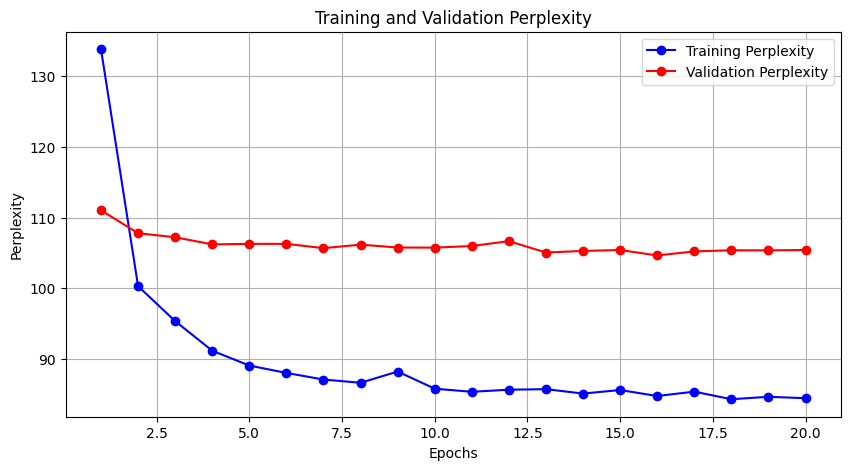

In [ ]:
#Hyperparameters
# embed_size = 100#size for each word embedding
# hidden_size=256
# num_layers=1
# num_epochs=20
# batch_size=100
# dropout_rate=0.2
# sequence_length=10#no of words in a sequence
# learning_rate=0.01


train_perplexities, val_perplexities =train(model,data_loader_train, num_epochs, batch_size)
plot_perplexities(train_perplexities, val_perplexities)


In [ ]:
test(model, data_loader_test, criterion)

Test Loss: 4.5701, Test Perplexity: 96.5549


While the model is improving on the training set, both validation loss and perplexity are increasing after a certain point. This suggests the model may be beginning to overfit to the training data, memorizing specific patterns rather than learning to generalize.So increased the  dropout to 0.3 to prevent overfitting.Also,increased the batch size to 1000 to see if the model can learn better.

Epoch 0 - Train Loss: 4.826, Train Perplexity: 124.686, Val Loss: 4.786, Val Perplexity: 119.796
Epoch 1 - Train Loss: 4.529, Train Perplexity: 92.642, Val Loss: 4.761, Val Perplexity: 116.845
Epoch 2 - Train Loss: 4.522, Train Perplexity: 92.019, Val Loss: 4.757, Val Perplexity: 116.439
Epoch 3 - Train Loss: 4.426, Train Perplexity: 83.614, Val Loss: 4.766, Val Perplexity: 117.409
Epoch 4 - Train Loss: 4.404, Train Perplexity: 81.763, Val Loss: 4.771, Val Perplexity: 118.061
Epoch 5 - Train Loss: 4.394, Train Perplexity: 80.956, Val Loss: 4.768, Val Perplexity: 117.696
Epoch 6 - Train Loss: 4.385, Train Perplexity: 80.203, Val Loss: 4.773, Val Perplexity: 118.232
Epoch 7 - Train Loss: 4.378, Train Perplexity: 79.682, Val Loss: 4.768, Val Perplexity: 117.635
Epoch 8 - Train Loss: 4.373, Train Perplexity: 79.254, Val Loss: 4.757, Val Perplexity: 116.452
Epoch 9 - Train Loss: 4.369, Train Perplexity: 78.957, Val Loss: 4.760, Val Perplexity: 116.731
Epoch 10 - Train Loss: 4.366, Train Per

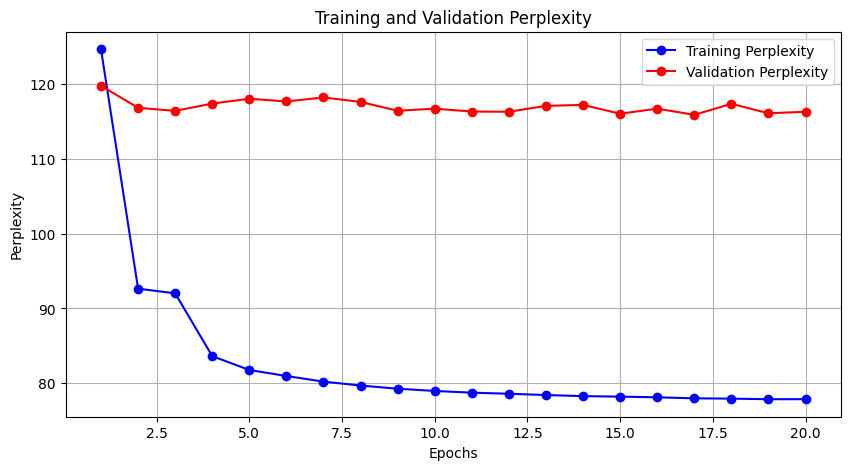

In [ ]:
# #Hyperparameters
# embed_size = 100#size for each word embedding
# hidden_size=256
# num_layers=1
# num_epochs=20
# batch_size=1000
# dropout_rate=0.3
# sequence_length=10#no of words in a sequence:time steps
# learning_rate=0.01

train_perplexities, val_perplexities =train(model,data_loader_train, num_epochs, batch_size)
plot_perplexities(train_perplexities, val_perplexities)

In [ ]:
test(model, data_loader_test, criterion)

Test Loss: 4.6731, Test Perplexity: 107.0266


Epoch 0 - Train Loss: 5.108, Train Perplexity: 165.291, Val Loss: 4.753, Val Perplexity: 115.895
Epoch 1 - Train Loss: 4.593, Train Perplexity: 98.817, Val Loss: 4.660, Val Perplexity: 105.668
Epoch 2 - Train Loss: 4.457, Train Perplexity: 86.262, Val Loss: 4.631, Val Perplexity: 102.619
Epoch 3 - Train Loss: 4.381, Train Perplexity: 79.908, Val Loss: 4.625, Val Perplexity: 102.021
Epoch 4 - Train Loss: 4.328, Train Perplexity: 75.799, Val Loss: 4.623, Val Perplexity: 101.832
Epoch 5 - Train Loss: 4.289, Train Perplexity: 72.886, Val Loss: 4.622, Val Perplexity: 101.726
Epoch 6 - Train Loss: 4.258, Train Perplexity: 70.658, Val Loss: 4.624, Val Perplexity: 101.903
Epoch 7 - Train Loss: 4.233, Train Perplexity: 68.904, Val Loss: 4.628, Val Perplexity: 102.302
Epoch 8 - Train Loss: 4.211, Train Perplexity: 67.456, Val Loss: 4.626, Val Perplexity: 102.104
Epoch 9 - Train Loss: 4.193, Train Perplexity: 66.226, Val Loss: 4.633, Val Perplexity: 102.808
Epoch 10 - Train Loss: 4.177, Train Per

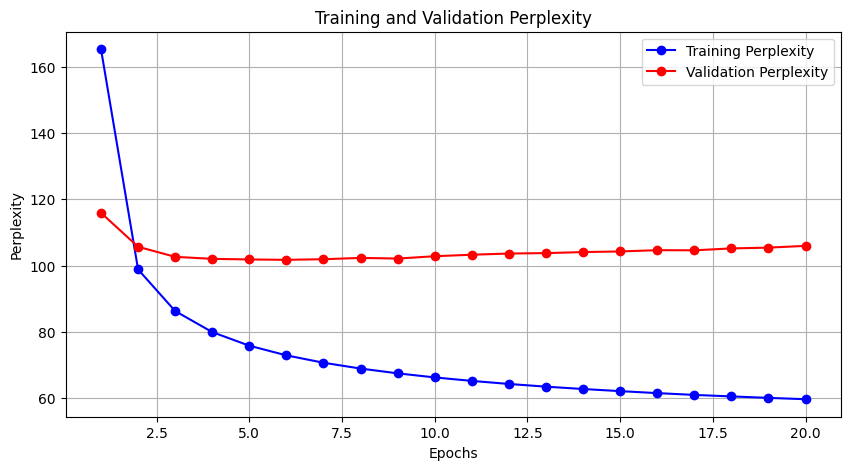

In [ ]:
# #Hyperparameters
# embed_size = 100#size for each word embedding
# hidden_size=256
# num_layers=1
# num_epochs=20
# batch_size=500
# dropout_rate=0.3
# sequence_length=10#no of words in a sequence:time steps
# learning_rate=0.01

train_perplexities, val_perplexities =train(model,data_loader_train, num_epochs, batch_size)
plot_perplexities(train_perplexities, val_perplexities)

There is a clear sign of overfitting.Our learning rate might be too low that model is converging too quickly to local sub-optimal.So trying a lower learning rate of 0.001.

Epoch 0 - Train Loss: 4.948, Train Perplexity: 140.887, Val Loss: 4.702, Val Perplexity: 110.135
Epoch 1 - Train Loss: 4.508, Train Perplexity: 90.697, Val Loss: 4.644, Val Perplexity: 103.920
Epoch 2 - Train Loss: 4.390, Train Perplexity: 80.673, Val Loss: 4.631, Val Perplexity: 102.599
Epoch 3 - Train Loss: 4.323, Train Perplexity: 75.418, Val Loss: 4.636, Val Perplexity: 103.141
Epoch 4 - Train Loss: 4.277, Train Perplexity: 72.008, Val Loss: 4.631, Val Perplexity: 102.635
Epoch 5 - Train Loss: 4.243, Train Perplexity: 69.583, Val Loss: 4.633, Val Perplexity: 102.784
Epoch 6 - Train Loss: 4.215, Train Perplexity: 67.683, Val Loss: 4.642, Val Perplexity: 103.728
Epoch 7 - Train Loss: 4.192, Train Perplexity: 66.136, Val Loss: 4.646, Val Perplexity: 104.174
Epoch 8 - Train Loss: 4.173, Train Perplexity: 64.884, Val Loss: 4.640, Val Perplexity: 103.504
Epoch 9 - Train Loss: 4.156, Train Perplexity: 63.845, Val Loss: 4.645, Val Perplexity: 104.084
Epoch 10 - Train Loss: 4.142, Train Per

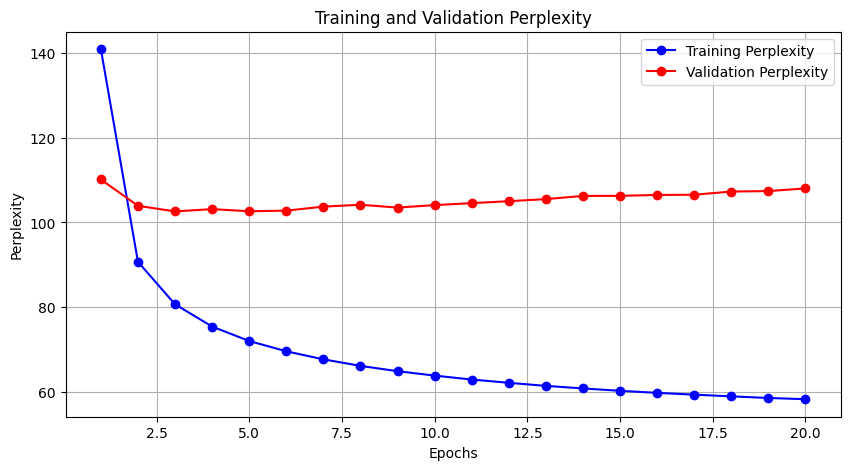

In [147]:
# embed_size = 100#size for each word embedding
# hidden_size=256
# num_layers=1
# num_epochs=20
# batch_size=500
# dropout_rate=0.3
# sequence_length=10#no of words in a sequence:time steps
# learning_rate=0.001

train_perplexities, val_perplexities =train(model,data_loader_train, num_epochs, batch_size)
plot_perplexities(train_perplexities, val_perplexities)

Still there is overfitting.The model is coverging too fast by 10 epochs and overfitting from then.So try to reduce the complexity of the model by reducing the hidden_size to 128

Epoch 0 - Train Loss: 5.131, Train Perplexity: 169.191, Val Loss: 4.769, Val Perplexity: 117.844
Epoch 1 - Train Loss: 4.718, Train Perplexity: 111.977, Val Loss: 4.688, Val Perplexity: 108.621
Epoch 2 - Train Loss: 4.609, Train Perplexity: 100.411, Val Loss: 4.650, Val Perplexity: 104.581
Epoch 3 - Train Loss: 4.548, Train Perplexity: 94.402, Val Loss: 4.630, Val Perplexity: 102.515
Epoch 4 - Train Loss: 4.507, Train Perplexity: 90.611, Val Loss: 4.618, Val Perplexity: 101.342
Epoch 5 - Train Loss: 4.476, Train Perplexity: 87.866, Val Loss: 4.614, Val Perplexity: 100.895
Epoch 6 - Train Loss: 4.451, Train Perplexity: 85.710, Val Loss: 4.609, Val Perplexity: 100.339
Epoch 7 - Train Loss: 4.432, Train Perplexity: 84.060, Val Loss: 4.603, Val Perplexity: 99.801
Epoch 8 - Train Loss: 4.414, Train Perplexity: 82.639, Val Loss: 4.602, Val Perplexity: 99.645
Epoch 9 - Train Loss: 4.400, Train Perplexity: 81.468, Val Loss: 4.598, Val Perplexity: 99.332
Epoch 10 - Train Loss: 4.388, Train Perp

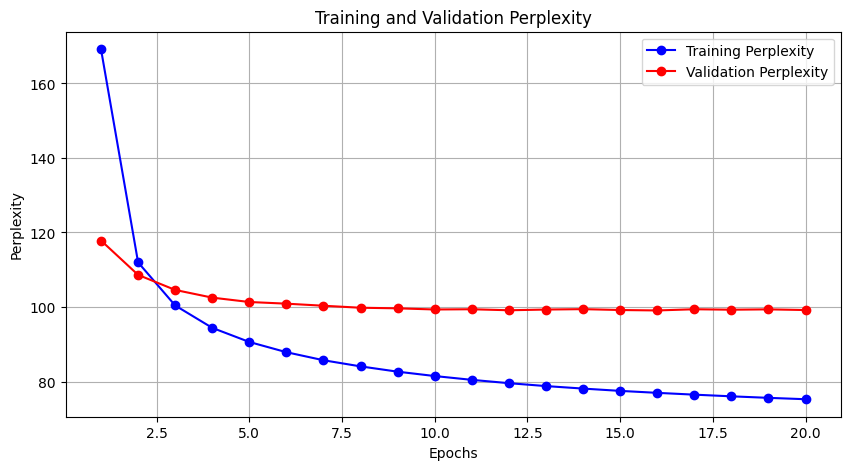

In [169]:
embed_size = 100#size for each word embedding
hidden_size=128
num_layers=1
num_epochs=20
batch_size=500
dropout_rate=0.3
sequence_length=10#no of words in a sequence:time steps
learning_rate=0.001

train_perplexities, val_perplexities =train(model,data_loader_train, num_epochs, batch_size)
plot_perplexities(train_perplexities, val_perplexities)

In [170]:
test(model, data_loader_test, criterion)

Test Loss: 4.5133, Test Perplexity: 91.2237
